In this notebook I will try to take a closer look at the data given to me and write my thoughts.

#### Import

In [128]:
import os, re
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

#### Constants

In [129]:
DATA_DIR = "data"
CHALLENGE_DATA_FILENAME = "data.csv"

#### Loading Data

In [130]:
filepath = os.path.join(DATA_DIR, CHALLENGE_DATA_FILENAME)
df_data = pd.read_csv(filepath, sep=",")

In [131]:
df_data_cpy = df_data.copy()

### General

In [132]:
df_data_cpy.head()

,language,proj_id,file_id,file_body
0,JavaScript,10001,100001,// Functions as values of a variable\nvar cube...
1,JavaScript,10001,100002,// Functions as values of a variable\nvar cube...
2,JavaScript,10002,100003,function median(ary) {\n if (ary.length == ...
3,JavaScript,10002,100004,"[\n null,\n 4,\n 3.5,\n 2.1\n]\n"
4,JavaScript,10002,100005,(() => {\n 'use strict';\n\n // median :...


In [133]:
print("Number of data samples: {}".format(df_data_cpy.shape[0]))

Number of data samples: 16272


In [134]:
print("Number of programming languages: {}".format(len(df_data_cpy["language"].unique())))
print("Distinct programming languages: {}".format(df_data_cpy["language"].unique()))

Number of programming languages: 19
Distinct programming languages: ['JavaScript' 'Swift' 'Python' 'Java' 'C++' 'Ruby' 'Rust' 'C' 'Scala' 'R'
 'Go' 'Mathematica' 'Kotlin' 'Fortran' 'Julia' 'PHP' 'MATLAB' 'Haskell'
 'Perl']


In [135]:
print("Number of projects: {}".format(len(df_data_cpy["proj_id"].unique())))

Number of projects: 10009


In [136]:
print("Number of unique file ids: {}".format(len(df_data_cpy["file_id"].unique())))

Number of unique file ids: 16272


In [137]:
print("Do any of columns have null values?")
for col in df_data_cpy.columns:
    print("   - {}".format(col).ljust(20) + ": {}".format(df_data_cpy[col].isnull().any()))

Do any of columns have null values?
   - language       : False
   - proj_id        : False
   - file_id        : False
   - file_body      : True


In [138]:
print("Rows ids with empty file body fields:")
df_data_cpy["file_body"][df_data_cpy["file_body"].isnull()]

Rows ids with empty file body fields:


1163     NaN
9951     NaN
12227    NaN
15290    NaN
Name: file_body, dtype: object

In [139]:
print("Removing rows with NaN 'file_body'")
df_data_cpy = df_data_cpy[~df_data_cpy["file_body"].isnull()]

Removing rows with NaN 'file_body'


#### Conclusions
- problem to solve is of classification type
- there are 19 different classes to predict
- no problem with class names (e.g. JavaScript vs javascript vs Java Script permutations)
- `file_id` is just an index field
- `proj_id` can have many files associated with it
- there were 4 samples with empty `file_body` and had to be removed
- model can only be based on features extracted via Natural Language Processing techniques

### Available samples per class

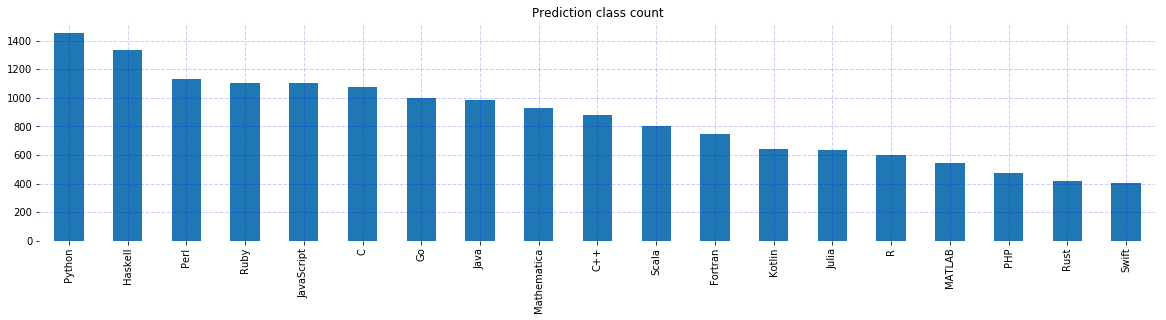

In [140]:
ax = df_data_cpy["language"].value_counts().plot("bar", figsize=(20,4))

ax.set_title("Prediction class count")
ax.grid(color='blue', linestyle='--', linewidth=1, alpha=0.2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False);

#### Conclusions
- there is unequal number of samples per class
- there is 'enough' data to build a model but as it's programming language classification problem then getting additional data from web shouldn't be a problem and would for sure help
- difference between samples number isn't very big but I am not sure if `accuracy` metric would work, as there is no business side related to the problem then it is impossible to say if `recall` or `precision` would be better metric so I would try also `f1_score` or `auc`
- for sure `k-fold cross validation` should be used for model validation and test set should contain all classes

### Length of code snipets

In [141]:
df_data_cpy["file_body_length"] = df_data_cpy["file_body"].apply(lambda x: len(x))

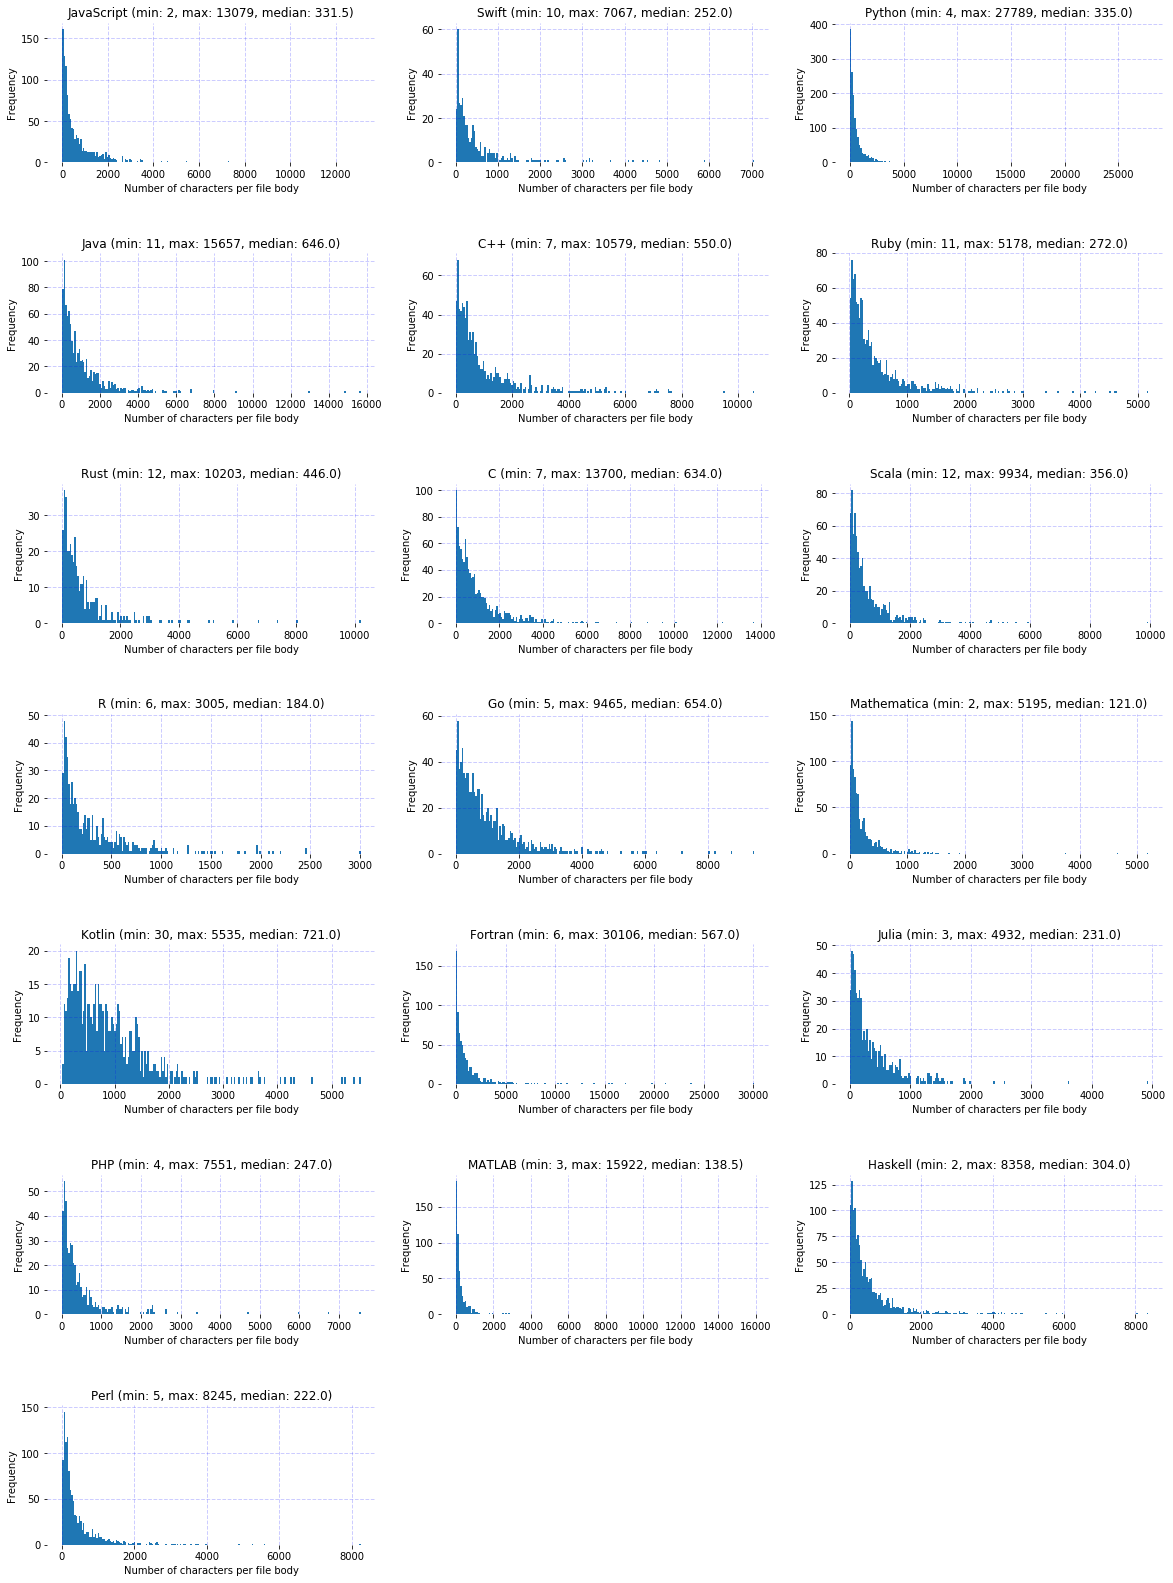

In [142]:
f, axarr = plt.subplots(
    int(np.ceil(len(df_data_cpy["language"].unique()) / 3)), 3, figsize=(20, 28))

plt.subplots_adjust(hspace=0.65, wspace=0.2)

row, col = 0, 0
for i, language in enumerate(df_data_cpy["language"].unique()):
    col = i % 3

    df = df_data_cpy.loc[df_data_cpy["language"] == language]    
    axarr[row, col].hist(df["file_body_length"], bins=200)
    axarr[row, col].set_title("{} (min: {}, max: {}, median: {})".format(
        language, df["file_body_length"].min(), df["file_body_length"].max(), 
        df["file_body_length"].median()))
    axarr[row, col].set_ylabel("Frequency")
    axarr[row, col].set_xlabel("Number of characters per file body")
    axarr[row, col].spines["top"].set_visible(False)
    axarr[row, col].spines["right"].set_visible(False)
    axarr[row, col].spines["bottom"].set_visible(False)
    axarr[row, col].spines["left"].set_visible(False)
    axarr[row, col].grid(color='blue', linestyle='--', linewidth=1, alpha=0.2)
#     axarr[row, col].set_xticks(np.arange(0, df_data_cpy["file_body_length"].max(), 4000))
#     axarr[row, col].set_yticks(np.arange(0, np.max(df_data_cpy["language"].value_counts()), 100))
    
    if col == 2:
        row += 1
        
for k in range(len(df_data_cpy["language"].unique()), (row + 1) * 3):
    axarr[row, k % 3].set_visible(False)

#### Conclusions
- majority of files has more than one hundred characters which is good
- I am curious about small files because they could not contain even a word - but only characters related to programming language (e.g. `{}` is a Python empty dictionary). It makes me think about data cleaning process - my first thought was to ignore character and focus on programming language words, but now I started to think that special characters are also very important

In [143]:
print("Shortest possible files per language: ")
for language in df_data_cpy["language"].unique():
    df = df_data_cpy.loc[(df_data_cpy["language"] == language)]
    df = df.loc[df["file_body_length"] == df["file_body_length"].min()]
    print("- {}:".format(language))
    print(repr(df["file_body"].as_matrix()[0]))
    print("\n")


Shortest possible files per language: 
- JavaScript:
'5\n'


- Swift:
'MyClass()\n'


- Python:
'2.3\n'


- Java:
'myMethod()\n'


- C++:
'int a;\n'


- Ruby:
'values.max\n'


- Rust:
'fn main(){}\n'


- C:
'int j;\n'


- Scala:
"val c = 'c'\n"


- R:
'> env\n'


- Go:
'&s{}\n'


- Mathematica:
'x\n'


- Kotlin:
'fun main(a: Array<String>) {}\n'


- Fortran:
'a = 0\n'


- Julia:
"A'\n"


- PHP:
'INF\n'


- MATLAB:
'pi\n'


- Haskell:
'\\\n'


- Perl:
'foo;\n'




#### Conclusions
- as I thought there will be files that doesn't have enough information to be classified to any language - `5` of `JavaScript` can be anything... 
- some data samples could be manually cleaned or samples with min character less than some reasonable threshold (let's say 15 characters) can be dropped
- this is very general problem, we should not be afraid to drop poor data, internet is endless source of it
- data can be left and used for training if we want to overfit to given dataset (because I wouldn't call training `5` = `JavaScript` as reasonable thing to do)

In [144]:
print("Samples lost per 'min_character_test' value: ")
for min_character_test in [10, 13, 15, 17, 20, 23, 25, 27, 30]:
    df = df_data_cpy.loc[df_data_cpy["file_body_length"] > min_character_test]
    diff = df_data.shape[0] - df.shape[0]
    print(" - {}: {} ({}%)".format(
        min_character_test, diff, np.round((diff * 100.0) / df_data.shape[0], 2)))

Samples lost per 'min_character_test' value: 
 - 10: 79 (0.49%)
 - 13: 149 (0.92%)
 - 15: 195 (1.2%)
 - 17: 239 (1.47%)
 - 20: 337 (2.07%)
 - 23: 428 (2.63%)
 - 25: 500 (3.07%)
 - 27: 567 (3.48%)
 - 30: 701 (4.31%)


### Sneak peek at code

In [145]:
print(df_data_cpy["file_body"].iloc[6466])

/*Abhishek Ghosh, 6th November 2013, Rotterdam*/
#include<graphics.h>
#include<conio.h>

int main()
{
	int d=DETECT,m,maxX,maxY,maxColours,i;
	initgraph(&d,&m,"c:/turboc3/bgi");
	maxX = getmaxx();
	maxY = getmaxy();
	maxColours = getmaxcolor();

	for(i=0;i<maxColours;i++)
	{
		setfillstyle(SOLID_FILL,i);
		bar(i*maxX/maxColours,0,(i+1)*maxX/maxColours,maxY);
	}

	getch();
	closegraph();
	
	return 0;
}



In [146]:
print(df_data_cpy["file_body"].iloc[1200])

let numberOfBytesUTF16 = "møøse".utf16.count * 2           // 10



In [147]:
print(df_data_cpy["file_body"].iloc[9002])

// Adapted from http://www-cs-faculty.stanford.edu/~uno/programs/topswops.w
// at Donald Knuth's web site.  Algorithm credited there to Pepperdine
// and referenced to Mathematical Gazette 73 (1989), 131-133.
package main

import "fmt"

const ( // array sizes
    maxn = 10 // max number of cards
    maxl = 50 // upper bound for number of steps
)

func main() {
    for i := 1; i <= maxn; i++ {
        fmt.Printf("%d: %d\n", i, steps(i))
    }
}

func steps(n int) int {
    var a, b [maxl][maxn + 1]int
    var x [maxl]int
    a[0][0] = 1
    var m int
    for l := 0; ; {
        x[l]++
        k := int(x[l])
        if k >= n {
            if l <= 0 {
                break
            }
            l--
            continue
        }
        if a[l][k] == 0 {
            if b[l][k+1] != 0 {
                continue
            }
        } else if a[l][k] != k+1 {
            continue
        }
        a[l+1] = a[l]
        for j := 1; j <= k; j++ {
            a[l+1][j] = a[l][k-j]
      

In [148]:
print(df_data_cpy["file_body"].iloc[2500])

>>> for n in (254, 255, 256, 257, -2+(1<<16), -1+(1<<16), 1<<16, 1+(1<<16), 0x200000, 0x1fffff ):
    print('int: %7i bin: %26s vlq: %35s vlq->int: %7i' % (n, tobits(n,_pad=True), tovlq(n), toint(tovlq(n))))


int:     254 bin:                   11111110 vlq:                   00000001_11111110 vlq->int:     254
int:     255 bin:                   11111111 vlq:                   00000001_11111111 vlq->int:     255
int:     256 bin:          00000001_00000000 vlq:                   00000010_10000000 vlq->int:     256
int:     257 bin:          00000001_00000001 vlq:                   00000010_10000001 vlq->int:     257
int:   65534 bin:          11111111_11111110 vlq:          00000011_11111111_11111110 vlq->int:   65534
int:   65535 bin:          11111111_11111111 vlq:          00000011_11111111_11111111 vlq->int:   65535
int:   65536 bin: 00000001_00000000_00000000 vlq:          00000100_10000000_10000000 vlq->int:   65536
int:   65537 bin: 00000001_00000000_00000001 vlq:          000

In [149]:
print(df_data_cpy["file_body"].iloc[6500])

#include <stdio.h>
#include <X11/Xlib.h>

int main()
{
  Display *d;
  Window inwin;      /* root window the pointer is in */
  Window inchildwin; /* child win the pointer is in */
  int rootx, rooty; /* relative to the "root" window; we are not interested in these,
                       but we can't pass NULL */
  int childx, childy;  /* the values we are interested in */
  Atom atom_type_prop; /* not interested */
  int actual_format;   /* should be 32 after the call */
  unsigned int mask;   /* status of the buttons */
  unsigned long n_items, bytes_after_ret;
  Window *props; /* since we are interested just in the first value, which is
		    a Window id */

  /* default DISPLAY */
  d = XOpenDisplay(NULL);

  /* ask for active window (no error check); the client must be freedesktop
     compliant */
  (void)XGetWindowProperty(d, DefaultRootWindow(d),
			   XInternAtom(d, "_NET_ACTIVE_WINDOW", True),
			   0, 1, False, AnyPropertyType,
			   &atom_type_prop, &actual_format,
			   &

#### Conclusions

- code contains coments, special characters, numbers, links, people names, languages other than english
- seems like apart from words the special characters and special character + word sequences are important in classifying programming language (Word2Vec + LSTM maybe could be useful? As LSTM is capable of text generation and grasping the structure of characters...)
- maybe removing digits could improve model performance as they appear everywhere
- missleading words like names, links should appear rarely so it will be good idea to drop words with low frequency from dictionary

### Most popular programming words

In [150]:
def tokenize(x):
    words = re.findall('(?u)\\b\\w\\w+\\b', x)
    return [w.lower() for w in words]

In [151]:
word_counters = dict()
for language in df_data_cpy["language"].unique():
    df = df_data_cpy.loc[df_data_cpy["language"] == language]
    df_words = df["file_body"].apply(lambda x: tokenize(x))
    
    language_word_list = list()
    for words in df_words.as_matrix():
        language_word_list.extend(words)

    word_counters[language] = Counter(language_word_list)    
    
for key, counter in word_counters.items():
    print("------- {} -------".format(key))
    print("- most common 30 words:\n{}\n".format([w[0] for w in counter.most_common(30)]))
    
    print("- all words in {}: {}".format(key, len(counter.keys())))
    
    unique = [w for w in counter.keys() if 
              all(w not in c for k, c in word_counters.items() if k != key)]
    
    print("- unique words for {}: {}\n".format(key, len(unique)))
    
    for other_key, other_counter in word_counters.items():
        if key == other_key:
            continue
        
        top_thousand = [w for w in counter.keys()]
        other_top_thousand = [w for w in other_counter.keys()]
        shared_words = [i for i in top_thousand if i in other_top_thousand]
        print("- shared words with {}: {}".format(other_key, len(shared_words)))
        
    print("\n")

------- JavaScript -------
- most common 30 words:
['var', 'return', 'function', 'xs', 'length', 'if', 'const', 'for', 'this', 'map', 'math', 'the', 'int', 'array', 'string', 'of', 'new', 'concat', '10', 'log', 'to', 'console', 'join', 'in', 'let', 'slice', 'range', 'document', 'value', 'name']

- all words in JavaScript: 6481
- unique words for JavaScript: 1930

- shared words with Swift: 1386
- shared words with Python: 2958
- shared words with Java: 2738
- shared words with C++: 2495
- shared words with Ruby: 2596
- shared words with Rust: 1721
- shared words with C: 2816
- shared words with Scala: 2437
- shared words with R: 1809
- shared words with Go: 2892
- shared words with Mathematica: 1800
- shared words with Kotlin: 2425
- shared words with Fortran: 2490
- shared words with Julia: 1849
- shared words with PHP: 1777
- shared words with MATLAB: 1592
- shared words with Haskell: 2841
- shared words with Perl: 2549


------- Swift -------
- most common 30 words:
['let', 'var', '

- shared words with PHP: 1686
- shared words with MATLAB: 1560
- shared words with Haskell: 2853
- shared words with Perl: 2680


------- R -------
- most common 30 words:
['function', 'if', 'the', 'in', 'print', 'length', 'for', 'cat', 'list', 'else', 'is', 'true', 'to', '10', 'as', 'of', 'paste', 'return', 'false', 'data', 'and', 'file', 'sum', 'matrix', 'col', 'value', 'sample', 'seq', 'ttl', 'while']

- all words in R: 3550
- unique words for R: 758

- shared words with JavaScript: 1809
- shared words with Swift: 999
- shared words with Python: 2138
- shared words with Java: 1845
- shared words with C++: 1763
- shared words with Ruby: 1872
- shared words with Rust: 1237
- shared words with C: 1980
- shared words with Scala: 1726
- shared words with Go: 2038
- shared words with Mathematica: 1356
- shared words with Kotlin: 1694
- shared words with Fortran: 1824
- shared words with Julia: 1398
- shared words with PHP: 1285
- shared words with MATLAB: 1281
- shared words with Haskell:

- shared words with Go: 3558
- shared words with Mathematica: 2206
- shared words with Kotlin: 3047
- shared words with Fortran: 2861
- shared words with Julia: 2255
- shared words with PHP: 1781
- shared words with MATLAB: 1824
- shared words with Perl: 3076


------- Perl -------
- most common 30 words:
['my', 'print', 'sub', 'use', 'if', 'for', 'return', 'the', 'shift', 'qw', 'and', 'to', 'is', 'map', 'new', 'while', '10', 'of', 'or', 'strict', 'say', 'join', 'next', 'perl', 'push', 'foreach', 'sum', 'die', 'self', 'int']

- all words in Perl: 6348
- unique words for Perl: 1403

- shared words with JavaScript: 2549
- shared words with Swift: 1432
- shared words with Python: 3643
- shared words with Java: 2947
- shared words with C++: 2771
- shared words with Ruby: 3196
- shared words with Rust: 1843
- shared words with C: 3422
- shared words with Scala: 2680
- shared words with R: 1848
- shared words with Go: 3267
- shared words with Mathematica: 2033
- shared words with Kotlin: 262

#### Conclusions
- it's tempting to use only unique words for programming language as a dictionary, but such model based on such solution won't work from data from outside dataset too well, especially for small code snippets 
- after removing digits and low frequency characters then number of unique characters per programming language should go down